# Exploration of data to determine a test and training set

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray.plot as xplt
import cftime

In [3]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

In [43]:
london_gcmdata = xr.open_mfdataset("../../../../derived_data/60km-london/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_19801201-19811130.nc")
london_linear_regridded_gcmdata = xr.open_mfdataset('../../../../derived_data/60km-lin-regrid-2.2km-london/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_19801201-19811130.nc')
london_nn_regridded_gcmdata = xr.open_mfdataset('../../../../derived_data/60km-nn-regrid-2.2km-london/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_19801201-19811130.nc')
london_cpmdata = xr.open_mfdataset("../../../../derived_data/2.2km-london/rcp85/01/pr/day/pr_rcp85_land-cpm_uk_2.2km_01_day_19801201-19811130.nc")

In [34]:
def plot_latlong_chunk(data, variable='pr'):
    plt.figure(figsize=(14,6))

    ax = plt.axes(projection=cp_model_rotated_pole)

    data[variable].plot(ax=ax, x='longitude', y='latitude', add_colorbar=False, transform=platecarree)

    ax.coastlines()
    
    plt.show()

In [35]:
def plot_rp_chunk(data, variable='pr'):
    plt.figure(figsize=(14,6))

    ax = plt.axes(projection=cp_model_rotated_pole)

    data[variable].plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=False, transform=cp_model_rotated_pole)

    ax.coastlines()
    
    plt.show()

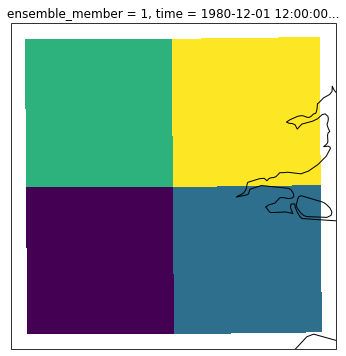

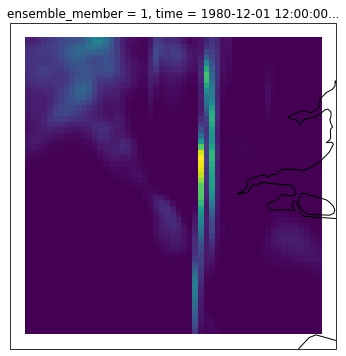

In [36]:
plot_latlong_chunk(london_gcmdata.sel(time="1980-12-01"))
plot_latlong_chunk(london_cpmdata.sel(time="1980-12-01"))

In [56]:
london_data = xr.merge([london_linear_regridded_gcmdata, london_cpmdata.rename({'pr': 'target_pr', 'ensemble_member_id': 'cpm_ensemble_member_id'})], join='inner')
london_data

<xarray.Dataset>
Dimensions:                     (bnds: 2, ensemble_member: 1, grid_latitude: 53, grid_longitude: 53, time: 360)
Coordinates:
  * ensemble_member             (ensemble_member) int32 1
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
  * grid_latitude               (grid_latitude) float64 -1.5 -1.48 ... -0.46
  * grid_longitude              (grid_longitude) float64 361.1 361.1 ... 362.1
    ensemble_member_id          (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    month_number                (time) int32 dask.array<chunksize=(360,), meta=np.ndarray>
    year                        (time) int32 dask.array<chunksize=(360,), meta=np.ndarray>
    yyyymmdd                    (time) |S64 dask.array<chunksize=(360,), meta=np.ndarray>
    cpm_ensemble_member_id      (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude                    (grid_latitude, grid_longitude) float64 dask.array<chunksize=(53, 53), meta=np.ndarray>
    longitude                   (grid_latitude, grid_longitude) float64 dask.array<chunksize=(53, 53), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr                          (ensemble_member, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 360, 53, 53), meta=np.ndarray>
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    grid_latitude_bnds          (grid_latitude, bnds) float64 dask.array<chunksize=(53, 2), meta=np.ndarray>
    grid_longitude_bnds         (grid_longitude, bnds) float64 dask.array<chunksize=(53, 2), meta=np.ndarray>
    target_pr                   (ensemble_member, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 360, 53, 53), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [67]:
london_data['pr'].values.shape

(1, 360, 53, 53)

In [51]:
london_cpmdata.ensemble_member_id.values

array([b'HadREM3-RA11M-r001i1p00000 '], dtype='|S27')

# Extract wettest 10% of days

In [22]:
# Find the timestamps of the wettest 100 days (for a single ensemble member), where wetness of a day is defined simply as the summation of pr of all the grid squares for that day
wettest_100_days = london_gcmdata.sum(dim=['projection_x_coordinate', 'projection_y_coordinate']).sortby('pr').isel(time=slice(-101, -1)).time.values

In [23]:
wettest_100_london_gcmdata = london_gcmdata.where(london_gcmdata.time.isin(wettest_100_days), drop=True)
wettest_100_london_gcmdata

<xarray.Dataset>
Dimensions:                       (bnds: 2, projection_x_coordinate: 2, projection_y_coordinate: 2, time: 100)
Coordinates:
    ensemble_member               int32 1
  * time                          (time) object 1981-12-01 12:00:00 ... 1982-...
  * projection_y_coordinate       (projection_y_coordinate) float64 1.5e+05 2...
  * projection_x_coordinate       (projection_x_coordinate) float64 5.1e+05 5...
    ensemble_member_id            |S27 dask.array<chunksize=(), meta=np.ndarray>
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    month_number                  (time) int32 dask.array<chunksize=(100,), meta=np.ndarray>
    year                          (time) int32 dask.array<chunksize=(100,), meta=np.ndarray>
    yyyymmdd                      (time) |S64 dask.array<chunksize=(100,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr                            (time, projection_y_coordinate, projection_x_coordinate) float32 dask.array<chunksize=(100, 2, 2), meta=np.ndarray>
    transverse_mercator           (time) float64 -2.147e+09 ... -2.147e+09
    time_bnds                     (time, bnds) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float64 dask.array<chunksize=(100, 2, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float64 dask.array<chunksize=(100, 2, 2), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.5

# Turn numpy variable files into Dataloader

In [21]:
import torch

In [22]:
from torch.utils.data import random_split, DataLoader, TensorDataset

In [37]:
variables = ['pr', 'psl']
lo_res_files = [ f'../../../../derived_data/60km-2.2km-regrid-lin-london/numpy/rcp85/01/{var}/day/{var}.npy' for var in variables ]

unstacked_X = map(torch.tensor, map(np.load, lo_res_files))
X = torch.stack(list(unstacked_X), dim=1)

hi_res_file = '../../../../derived_data/2.2km-london/numpy/rcp85/01/pr/day/pr.npy'

y = torch.tensor(np.load(hi_res_file)).unsqueeze(dim=1)

all_data = TensorDataset(X, y)

train_size = int(0.7 * len(all_data))
val_size = len(all_data) - train_size
train_set, val_set = random_split(all_data, [train_size, val_size])

train_dl = DataLoader(train_set, batch_size=64)
val_dl = DataLoader(val_set, batch_size=64)